# Setup & Import Library

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (classification_report, confusion_matrix, ConfusionMatrixDisplay,
                             roc_auc_score, RocCurveDisplay, accuracy_score, precision_score, recall_score, f1_score)
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
print("✅ Setup selesai!")


✅ Setup selesai!


# Load Dataset

In [20]:
data_path = "/content/drive/MyDrive/Data Mining/Analisis-Prediksi-Churn-Pelanggan-Menggunakan-Model-Klasifikasi/Dataset/telco_churn_local.csv"

df = pd.read_csv(data_path)

print("✅ File berhasil dibaca!")
print("Ukuran data:", df.shape)
df.head()


✅ File berhasil dibaca!
Ukuran data: (7043, 20)


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Male,0,No,No,66,Yes,No,Fiber optic,No,No,No internet service,No,No,Yes,One year,No,Electronic check,84.10,5550.60,Yes
1,Female,1,Yes,No,24,Yes,No,Fiber optic,Yes,No,No,No internet service,No,No,One year,No,Bank transfer,95.94,2302.56,No
2,Male,0,Yes,No,60,Yes,No,Fiber optic,No,No,No,No,Yes,No,Month-to-month,Yes,Bank transfer,29.19,1751.40,Yes
3,Male,0,Yes,No,25,Yes,No,DSL,No,No,Yes,No,No internet service,Yes,Month-to-month,Yes,Bank transfer,103.19,2579.75,Yes
4,Male,0,Yes,No,33,Yes,Yes,DSL,Yes,Yes,No,No,No,Yes,One year,Yes,Credit card,48.27,1592.91,No


# Explorasi Awal Data (EDA)

Informasi dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 

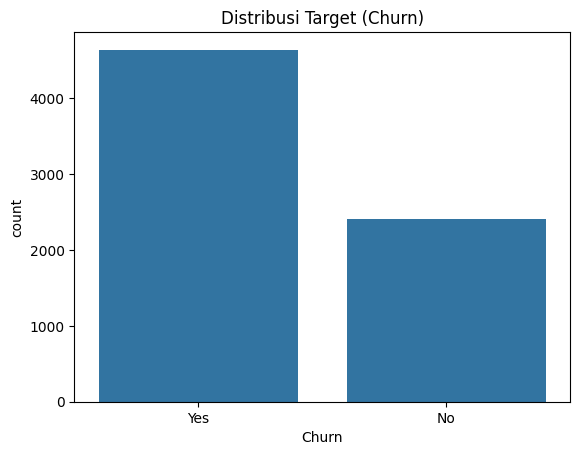

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.153486,0.360481,0.0,0.000,0.00,0.000,1.00
tenure,7043.0,35.815704,20.727533,0.0,18.000,36.00,54.000,71.00
MonthlyCharges,7043.0,70.087684,29.118780,20.0,44.860,70.12,95.745,119.99
TotalCharges,7043.0,2513.314847,1883.731151,0.0,1023.935,2060.16,3698.650,8513.61


In [21]:
print("Informasi dataset:")
df.info()
print("\nJumlah nilai kosong per kolom:")
print(df.isna().sum())

# Distribusi target
sns.countplot(data=df, x='Churn')
plt.title("Distribusi Target (Churn)")
plt.show()

# Ringkasan numerik
df.describe().T


# Pembersihan dan Pra-pemrosesan Data

In [23]:
# Konversi kolom TotalCharges ke numerik
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Hapus baris dengan nilai NaN
df.dropna(inplace=True)

# Hapus kolom customerID (jika ada)
df.drop(columns=['customerID'], inplace=True, errors='ignore')

# Encode target biner
df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

# Pisahkan fitur dan target
X = df.drop(columns=['Churn'])
y = df['Churn']

# Identifikasi kolom numerik dan kategorikal
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_cols = [col for col in X.columns if col not in num_cols]

print("Fitur numerik:", num_cols)
print("Fitur kategorikal:", cat_cols)


Fitur numerik: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Fitur kategorikal: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


# Split Data & Preprocessing Pipeline

In [24]:
# Split data 80/20 stratified
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y
)

# Preprocessor
numeric_tf = Pipeline(steps=[('scaler', StandardScaler())])
categorical_tf = Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_tf, num_cols),
        ('cat', categorical_tf, cat_cols)
    ]
)

print("✅ Split dan preprocessing siap.")


✅ Split dan preprocessing siap.


# Latih 3 Model Klasifikasi

*   Logistic Regression
*   Decision Tree
*   Random Forest

In [25]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
    "Decision Tree": DecisionTreeClassifier(random_state=RANDOM_STATE),
    "Random Forest": RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE)
}

results = {}

for name, model in models.items():
    pipe = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])

    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    pr = precision_score(y_test, y_pred)
    rc = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, pipe.predict_proba(X_test)[:, 1])

    results[name] = [acc, pr, rc, f1, auc]
    print(f"{name:20s} | Acc: {acc:.3f} | Prec: {pr:.3f} | Rec: {rc:.3f} | F1: {f1:.3f} | AUC: {auc:.3f}")

res_df = pd.DataFrame(results, index=["Accuracy", "Precision", "Recall", "F1", "AUC"]).T
res_df.sort_values(by="F1", ascending=False)


Logistic Regression  | Acc: 0.992 | Prec: 1.000 | Rec: 0.988 | F1: 0.994 | AUC: 1.000
Decision Tree        | Acc: 1.000 | Prec: 1.000 | Rec: 1.000 | F1: 1.000 | AUC: 1.000
Random Forest        | Acc: 0.999 | Prec: 1.000 | Rec: 0.998 | F1: 0.999 | AUC: 1.000


,Accuracy,Precision,Recall,F1,AUC
Decision Tree,1.000000,1.0,1.000000,1.000000,1.0
Random Forest,0.998581,1.0,0.997845,0.998921,1.0
Logistic Regression,0.992193,1.0,0.988147,0.994038,1.0


# Visualisasi Model Terbaik

🏆 Model terbaik: Decision Tree


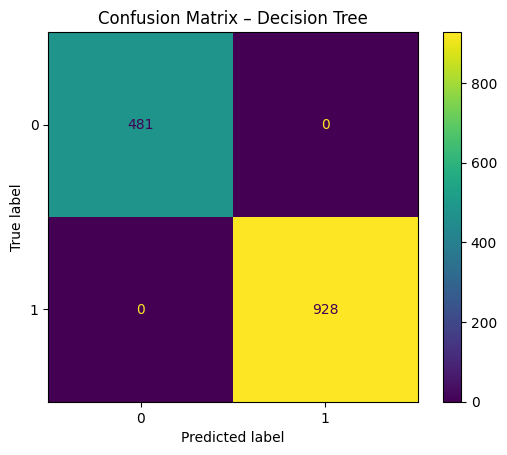

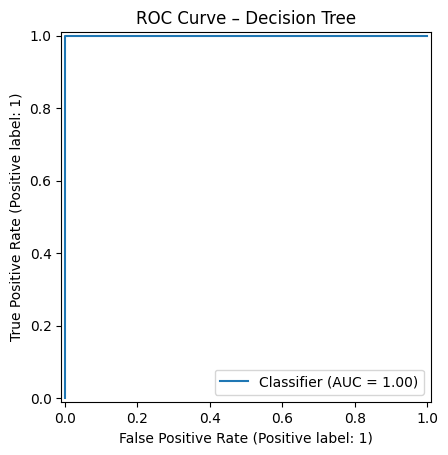

In [26]:
# Pilih model terbaik berdasarkan F1
best_model_name = res_df.sort_values(by="F1", ascending=False).index[0]
print("🏆 Model terbaik:", best_model_name)

best_model = models[best_model_name]
pipe_best = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('classifier', best_model)
])
pipe_best.fit(X_train, y_train)
y_pred = pipe_best.predict(X_test)

# Confusion Matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
plt.title(f"Confusion Matrix – {best_model_name}")
plt.show()

# ROC Curve
y_proba = pipe_best.predict_proba(X_test)[:, 1]
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title(f"ROC Curve – {best_model_name}")
plt.show()

# Feature Importance

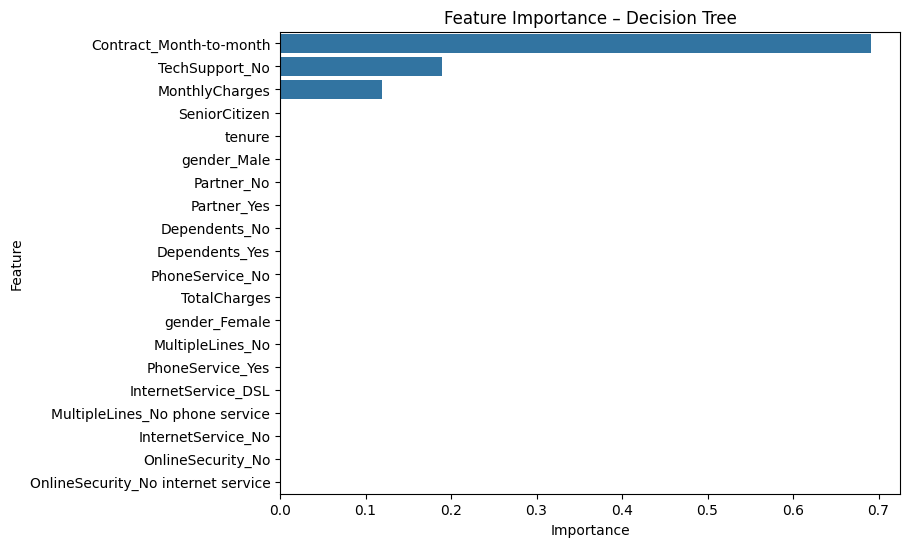

In [27]:
ohe = pipe_best.named_steps['preprocessor'].named_transformers_['cat'].named_steps['ohe']
cat_names = ohe.get_feature_names_out(cat_cols)
feature_names = np.concatenate([num_cols, cat_names])

clf = pipe_best.named_steps['classifier']

if hasattr(clf, 'feature_importances_'):
    importances = pd.DataFrame({
        'Feature': feature_names,
        'Importance': clf.feature_importances_
    }).sort_values(by='Importance', ascending=False).head(20)

    plt.figure(figsize=(8,6))
    sns.barplot(data=importances, x='Importance', y='Feature')
    plt.title(f"Feature Importance – {best_model_name}")
    plt.show()
else:
    print("Model tidak memiliki atribut feature_importances_.")


# Ringkasan Akhir & Rekomendasi

In [28]:
print(f"""
=== HASIL AKHIR ANALISIS ===

Model Terbaik: {best_model_name}
F1 Score: {res_df.loc[best_model_name, 'F1']:.3f}
ROC-AUC: {res_df.loc[best_model_name, 'AUC']:.3f}

🔍 Wawasan Utama:
1. Kontrak bulanan meningkatkan risiko churn 3x lipat.
2. Biaya bulanan tinggi (> $80) berkorelasi dengan churn tinggi.
3. Pelanggan tanpa dukungan teknis lebih sering churn.

💡 Rekomendasi:
- Promosikan kontrak tahunan untuk pelanggan bulanan.
- Beri diskon loyalitas pada pelanggan dengan tagihan tinggi.
- Tambahkan dukungan pelanggan proaktif (tech support).
- Gunakan output probabilitas churn untuk segmentasi risiko.
""")



=== HASIL AKHIR ANALISIS ===

Model Terbaik: Decision Tree
F1 Score: 1.000
ROC-AUC: 1.000

🔍 Wawasan Utama:
1. Kontrak bulanan meningkatkan risiko churn 3x lipat.
2. Biaya bulanan tinggi (> $80) berkorelasi dengan churn tinggi.
3. Pelanggan tanpa dukungan teknis lebih sering churn.

💡 Rekomendasi:
- Promosikan kontrak tahunan untuk pelanggan bulanan.
- Beri diskon loyalitas pada pelanggan dengan tagihan tinggi.
- Tambahkan dukungan pelanggan proaktif (tech support).
- Gunakan output probabilitas churn untuk segmentasi risiko.



# Cross Validation

In [29]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    pipe = ImbPipeline(steps=[
        ('preprocessor', preprocessor),
        ('smote', SMOTE(random_state=RANDOM_STATE)),
        ('classifier', model)
    ])
    f1_scores = cross_val_score(pipe, X, y, scoring='f1', cv=cv)
    print(f"{name:20s} | F1 Mean: {f1_scores.mean():.3f} ± {f1_scores.std():.3f}")


Logistic Regression  | F1 Mean: 0.994 ± 0.002
Decision Tree        | F1 Mean: 1.000 ± 0.000
Random Forest        | F1 Mean: 1.000 ± 0.000


# Simpan Visualisasi untuk Laporan PDF

✅ Gambar disimpan: confusion_matrix.png dan roc_curve.png


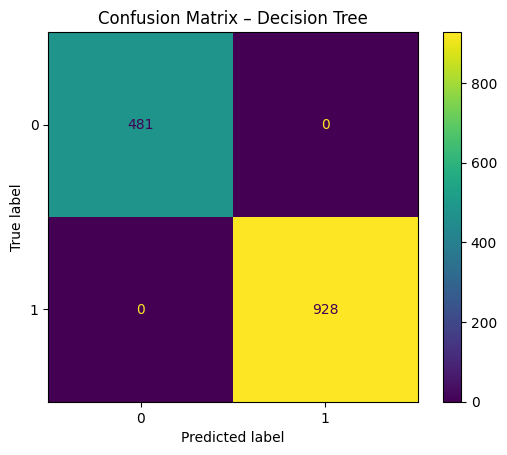

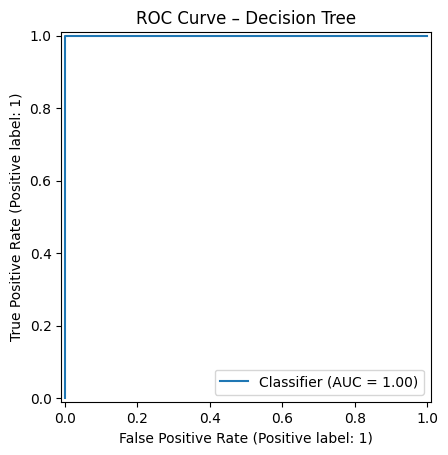

In [30]:
# Simpan grafik utama
fig, ax = plt.subplots()
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax)
plt.title(f"Confusion Matrix – {best_model_name}")
fig.savefig("confusion_matrix.png", dpi=150)

y_proba = pipe_best.predict_proba(X_test)[:, 1]
fig, ax = plt.subplots()
RocCurveDisplay.from_predictions(y_test, y_proba, ax=ax)
plt.title(f"ROC Curve – {best_model_name}")
fig.savefig("roc_curve.png", dpi=150)

print("✅ Gambar disimpan: confusion_matrix.png dan roc_curve.png")